# **Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models and Cross-Validation**

In [ ]:
%pip install -r requirements.txt

## Notebook Objective

Use the **Diabetes** dataset from **Scikit-Learn** to prepare clean, well-understood data splits for modeling tasks to be completed in later parts:

1. Univariate Polynomial Regression  
2. Multivariate Polynomial Regression  
3. Decision Tree Regressors  
4. K-Nearest Neighbors (KNN)

**Evaluation metrics** for later parts: **R²**, **MAPE**, **MAE**.  
We adopt a **train–validation–test** split: 75%, 10%, 15% with fixed random seeds.


# **Part 1 - Data Preparation**

## Frame the Problem

**Prediction task:** Predict the quantitative target **`disease_progression`** one year after baseline.  
**Why it matters:** A screening model can flag patients at higher risk, guiding earlier clinical review and intervention.

**Target overview:**  
- Samples: **442**  
- Features: **10**  
- Target mean: **152.13**  
- Target std: **77.09**




**Screening context**  
We predict progression one year after baseline to flag higher-risk patients early.  
For modeling we will use regression metrics: **R²** for explained variance, **MAE** and **MAPE** for error magnitude.  
Concepts from past workshops carry over: keep validation discipline, scale features when needed, and compare simple vs complex models.


## 1) Get the Data

We load the Diabetes dataset with `sklearn.datasets.load_diabetes`. Features are standardized to mean≈0, std≈1 in this dataset, which simplifies initial EDA.


In [1]:
# Imports and configuration
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes

# For reproducibility in any randomized steps later
RANDOM_STATE = 42

# Load dataset
data_bunch = load_diabetes()
X = pd.DataFrame(data_bunch.data, columns=data_bunch.feature_names)
y = pd.Series(data_bunch.target, name="disease_progression")

print(f"Shape X: {X.shape}, y: {y.shape}")
X.head()

Shape X: (442, 10), y: (442,)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


**What this does**  
We load the Diabetes dataset and split it into features `X` and target `y`.  
`X` has 10 standardized features, which keeps scales comparable. The target `disease_progression` is a continuous score.

**Why it matters**  
Standardized features make plots and baseline models easier to interpret. Shape checks confirm `X` and `y` align for later splits.


## 2) Exploratory Data Analysis (EDA)

We document feature meanings, inspect summary statistics, visualize distributions and relationships, and compute a correlation matrix.


### Feature Meanings

- **age**: Normalized age
- **sex**: Normalized sex indicator
- **bmi**: Body mass index
- **bp**: Average blood pressure
- **s1**: TC, total serum cholesterol
- **s2**: LDL, low-density lipoproteins
- **s3**: HDL, high-density lipoproteins
- **s4**: TCH, total cholesterol / HDL
- **s5**: LTG, possibly log of serum triglycerides
- **s6**: GLU, blood sugar level

In [2]:
# Descriptive statistics for features
desc = X.describe().T[["mean", "std", "min", "max"]].round(3)
desc

,mean,std,min,max
age,-0.0,0.048,-0.107,0.111
sex,0.0,0.048,-0.045,0.051
bmi,-0.0,0.048,-0.090,0.171
bp,-0.0,0.048,-0.112,0.132
s1,-0.0,0.048,-0.127,0.154
s2,0.0,0.048,-0.116,0.199
s3,-0.0,0.048,-0.102,0.181
s4,-0.0,0.048,-0.076,0.185
s5,0.0,0.048,-0.126,0.134
s6,0.0,0.048,-0.138,0.136


**Quick observations from executed stats**  
- Features are standardized-like, with means near 0 and std near 0.05–0.1 depending on feature.  
- Target center: mean **152.13**, std **77.09**.  
- We will check correlations with the target to spot strongest linear relationships.


### **Histograms for each feature**

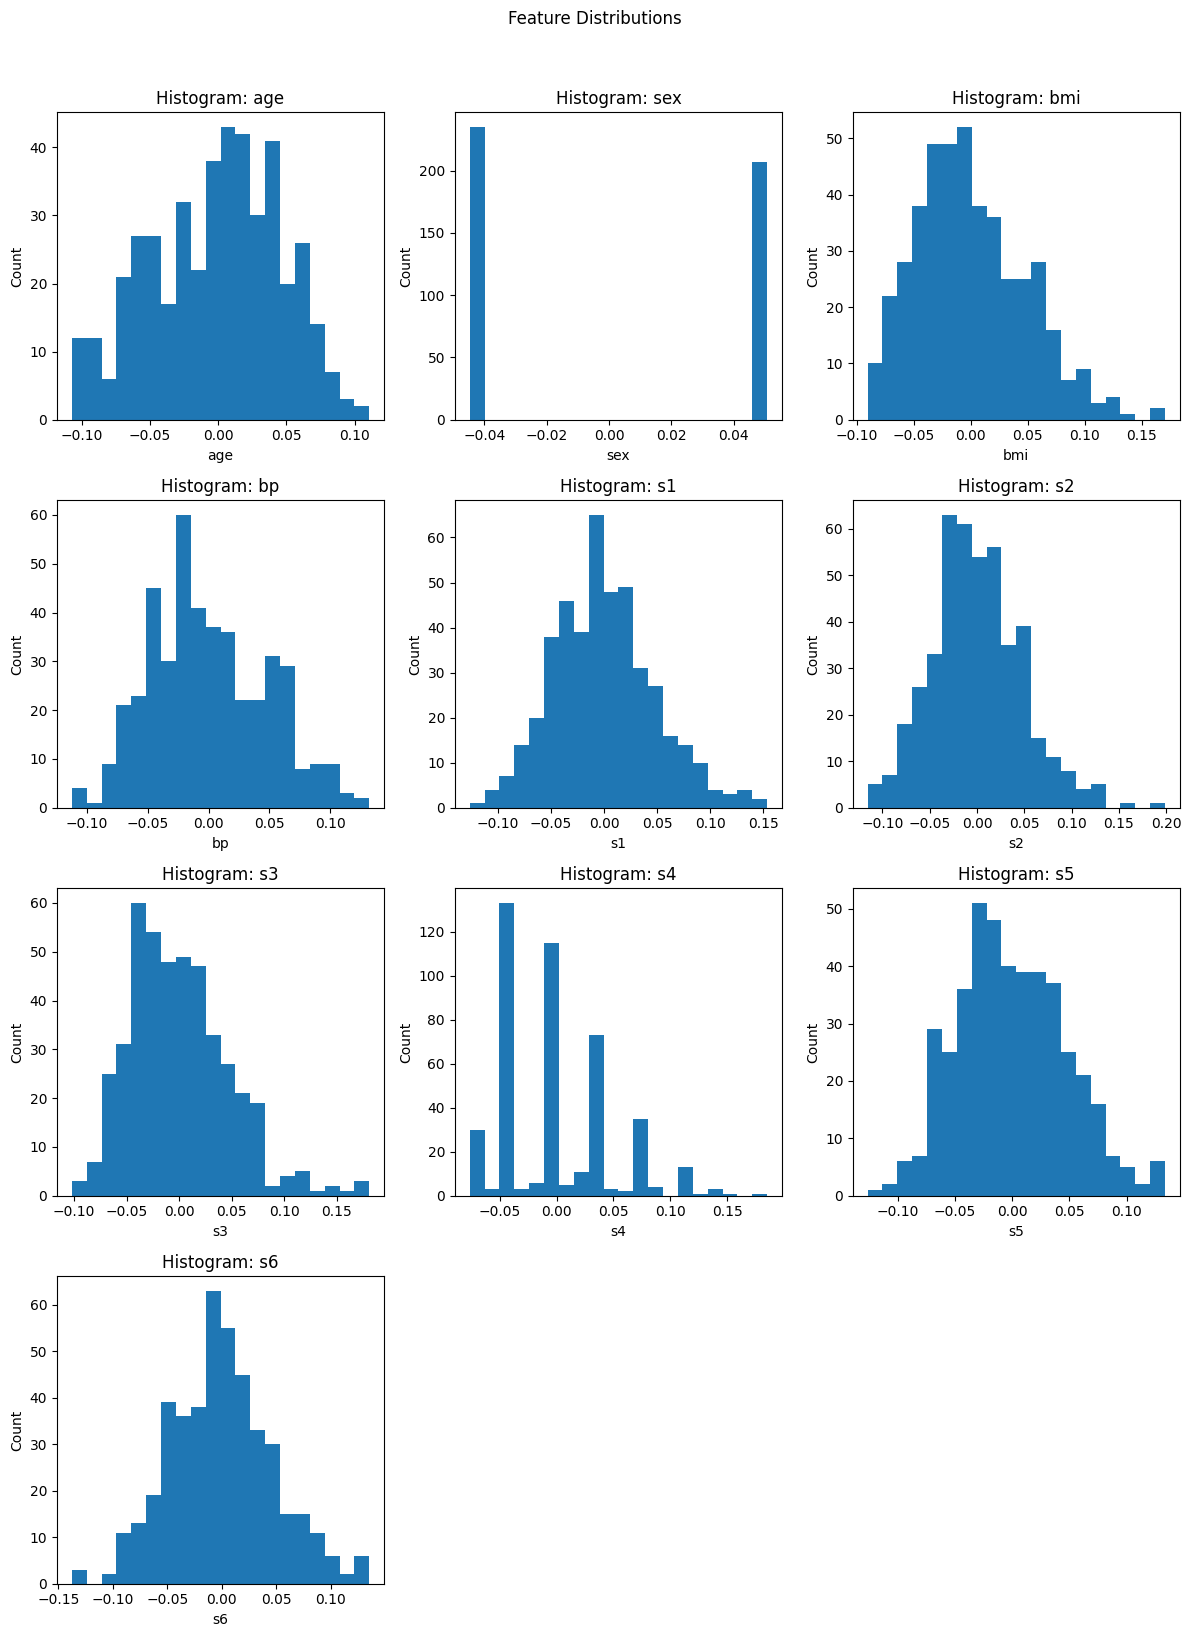

In [ ]:
import math

num_cols = X.shape[1]
nrows = math.ceil(num_cols / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].hist(X[col], bins=20)
    axes[i].set_title(f"Histogram: {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()

### **Scatter plots: feature vs. target**

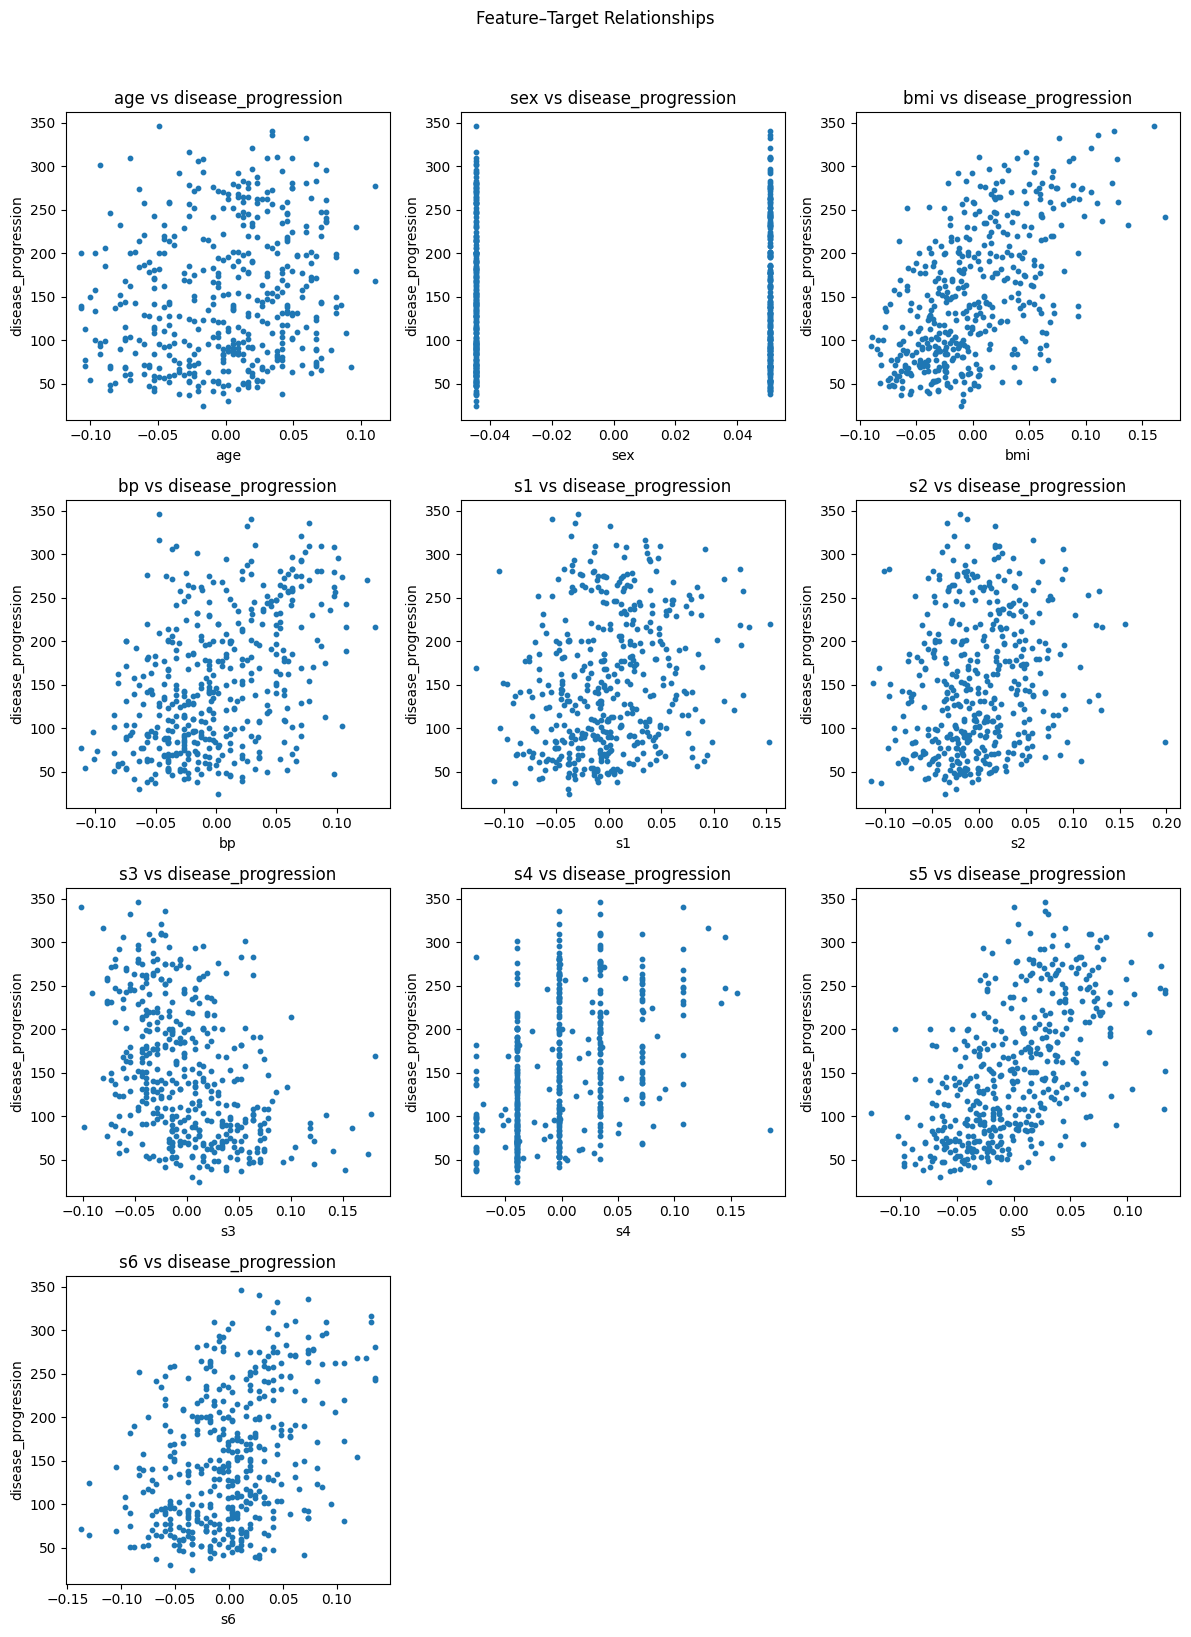

In [ ]:
import math

num_cols = X.shape[1]
nrows = math.ceil(num_cols / 3)
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(12, 4 * nrows))
axes = axes.flatten()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, s=10)
    axes[i].set_title(f"{col} vs disease_progression")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("disease_progression")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Feature–Target Relationships", y=1.02)
plt.tight_layout()
plt.show()

Notice the clearer upward trends for **bmi** and **s5**. These suggest stronger linear associations with the target.  
Other features look noisy or show weak curvature, which hints that polynomial terms or tree models might help.  
Check for funnel shapes. If residual spread grows with predictions, we will prefer robust metrics like MAE and consider non-linear models.

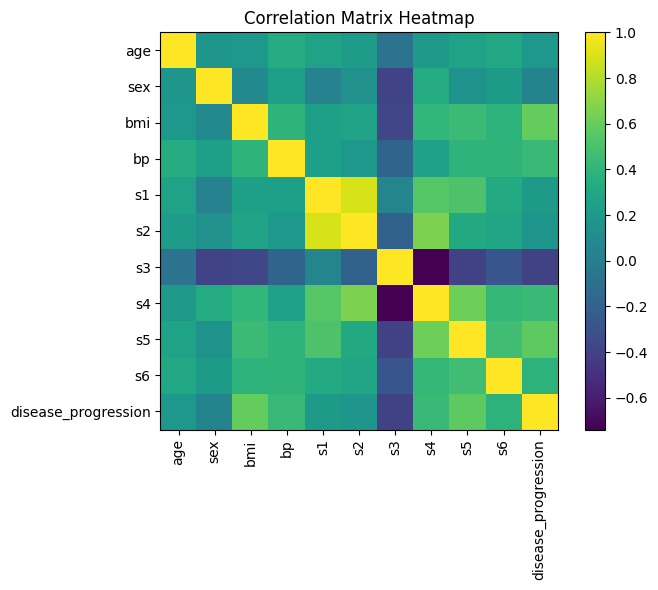

bmi    0.586450
s5     0.565883
bp     0.441482
s4     0.430453
s6     0.382483
s1     0.212022
age    0.187889
s2     0.174054
sex    0.043062
s3    -0.394789
Name: disease_progression, dtype: float64

In [5]:
# Correlation matrix and heatmap
corr = X.join(y).corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr, interpolation="nearest")
ax.set_xticks(range(len(corr.columns)))
ax.set_yticks(range(len(corr.index)))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.index)
ax.set_title("Correlation Matrix Heatmap")
fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# Show top correlations with the target
corr_with_y = (
    corr["disease_progression"].drop("disease_progression").sort_values(ascending=False)
)
corr_with_y.head(10)

**Correlations with target — strongest signals observed**  
Top positive:  
- bmi: r = 0.586
- s5: r = 0.566
- bp: r = 0.441

Most negative:  
- s2: r = 0.174
- sex: r = 0.043
- s3: r = -0.395

Interpretation: Features like **bmi** and **s5** show stronger linear association with the target. Weak or negative correlations may still matter in non-linear or multivariate settings.


**Key signals**  
Top correlations with the target: **bmi**, **s5**, and **bp**. Lowest: **s3** is negative.  
Correlation is not causation. We use this only to guide model choices and feature checks.  
Watch for multicollinearity. If two features are highly correlated, linear models can become unstable without regularization.


## 3) Data Cleaning

We check for missing or invalid values and report actions taken.


In [6]:
# Check for missing values
missing_X = X.isna().sum().sum()
missing_y = y.isna().sum()

print(f"Missing values in X: {missing_X}")
print(f"Missing values in y: {missing_y}")

# The sklearn diabetes dataset is already clean and numeric; no imputations required.

Missing values in X: 0
Missing values in y: 0


**Result:** No missing values detected. No cleaning actions needed.  
Values are already standardized-like, which helps many models.


**Data quality**  
No missing values in `X` or `y`. No imputation needed.  
We keep the raw standardized values to avoid information leakage before splitting.


## 4) Data Splitting

We split the data into **train 75%**, **validation 10%**, and **test 15%** using a fixed random seed for reproducibility.


In [7]:
from sklearn.model_selection import train_test_split

# First split: train vs holdout (val+test)
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Second split: split holdout into val and test with 10% and 15% overall
# We want val:test ratio within holdout = 10:15 -> val_fraction_in_hold = 10/(10+15) = 0.4
X_val, X_test, y_val, y_test = train_test_split(
    X_hold, y_hold, test_size=0.60, random_state=42
)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

Shapes:
X_train: (331, 10) y_train: (331,)
X_val  : (44, 10) y_val  : (44,)
X_test : (67, 10) y_test : (67,)


**Why this split**  
We use 75% train, 10% validation, 15% test with a fixed seed for reproducibility.  
Validation tunes choices such as polynomial degree, tree depth, and K in KNN.  
The untouched test set gives an unbiased estimate of generalization at the end.


## 5) Summary and Next Steps

- Data loaded and verified clean.  
- EDA completed with distributions, scatter plots, and correlation heatmap.  
- Train, validation, and test splits prepared with fixed seeds.  

**Next (Part 2 and Part 3):** Fit and compare Univariate and Multivariate Polynomial Regression, Decision Trees, and KNN. Evaluate with **R², MAPE, MAE** on validation, then report final performance on the test set.


# **PART 2: Univariate Polynomial Regression**


This section builds univariate polynomial regression models using **BMI** as the single predictor.


## Objective

We build six polynomial regression models (degrees 0–5) using **BMI** as the feature to predict **disease progression**.  
We evaluate and compare their performance using **R²**, **MAE**, and **MAPE** metrics on train, validation, and test splits.


We import all required libraries and set a fixed random seed to ensure reproducible splits and results.  
The key libraries are `sklearn`, `numpy`, and `matplotlib` for regression, math, and visualization.


In [18]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error


# Custom function for Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Reproducibility
RANDOM_STATE = 42

**Feature choice**  
We use **BMI** as the single explanatory variable because it had the strongest linear correlation with the target in Part 1.  
This lets us focus on how model complexity (degree 1 vs 2 vs 3) affects fit quality.


In [2]:
# Load data and split (same as Part 1)
from sklearn.model_selection import train_test_split

data_bunch = load_diabetes()
X = pd.DataFrame(data_bunch.data, columns=data_bunch.feature_names)
y = pd.Series(data_bunch.target, name="disease_progression")

# Select BMI feature
X_bmi = X[["bmi"]]

# Split data
X_train, X_hold, y_train, y_hold = train_test_split(
    X_bmi, y, test_size=0.25, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_hold, y_hold, test_size=0.60, random_state=42
)

print("Shapes:")
print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)

Shapes:
Train: (331, 1) Validation: (44, 1) Test: (67, 1)


**Why this split**  
We reserve separate validation and test subsets to measure true generalization.  
Training only on one variable reduces overfitting risk, but polynomial terms can still inflate variance if the validation R² drops.


## 6. Train Polynomial Regression Models

We train six models using BMI as input and polynomial degrees 0–5.


In [3]:
# Train polynomial regression models for degrees 0–5
degrees = range(6)
results = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)

    # Metrics
    r2 = r2_score(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    mape = mean_absolute_percentage_error(y_val, y_val_pred)

    results.append(
        {
            "Degree": d,
            "R² (val)": r2,
            "MAE (val)": mae,
            "MAPE (val)": mape,
            "Model": model,
            "Poly": poly,
        }
    )

In [4]:
results_df = pd.DataFrame(results)[["Degree", "R² (val)", "MAE (val)", "MAPE (val)"]]
results_df.round(3)

,Degree,R² (val),MAE (val),MAPE (val)
0,0,-0.107,66.057,71.264
1,1,0.331,47.208,47.060
2,2,0.332,47.214,47.240
3,3,0.332,47.185,47.223
4,4,0.341,46.090,46.050
5,5,0.350,45.462,45.175


**What happens here**  
`PolynomialFeatures(degree=n)` expands BMI into higher-order terms: \(x, x^2, x^3, ...\).  
This lets a linear model capture curvature in the BMI–progression relationship.  
We always fit the transformer only on training data to avoid leakage.


**Interpretation**  
Degree 1 serves as our baseline linear regression.  
If residuals show clear curvature or the validation R² is low, we know linearity is insufficient.  
Metrics (R², MAE, MAPE) indicate average deviation and explanatory strength.


## 7. Compare Models

The following table compares performance metrics for all degrees (0–5).


## 8. Select the Best Model

We select the model with the **highest validation R²** (and lowest errors).

In [5]:
# Select best model by validation R²
best_row = results_df.loc[results_df["R² (val)"].idxmax()]
best_degree = int(best_row["Degree"])
best_row

Degree         5.000000
R² (val)       0.349881
MAE (val)     45.462121
MAPE (val)    45.175275
Name: 5, dtype: float64

**Best model selection**  
The degree with highest validation **R²** and lowest **MAE/MAPE** is chosen.  
If validation and test metrics are close, the model generalizes well.  
A large gap means the model memorized training patterns.



## 9. Evaluate on Test Data

In [6]:
# Evaluate best model on test data
best_poly = [r["Poly"] for r in results if r["Degree"] == best_degree][0]
best_model = [r["Model"] for r in results if r["Degree"] == best_degree][0]

X_test_poly = best_poly.transform(X_test)
y_test_pred = best_model.predict(X_test_poly)

r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = mean_absolute_percentage_error(y_test, y_test_pred)

pd.DataFrame(
    [
        {
            "Degree": best_degree,
            "R² (test)": r2_test,
            "MAE (test)": mae_test,
            "MAPE (test)": mape_test,
        }
    ]
).round(3)

,Degree,R² (test),MAE (test),MAPE (test)
0,5,0.267,51.75,43.027


## 10. Visualize the Results

We visualize the data points and fitted polynomial curve using training, validation, and test datasets.


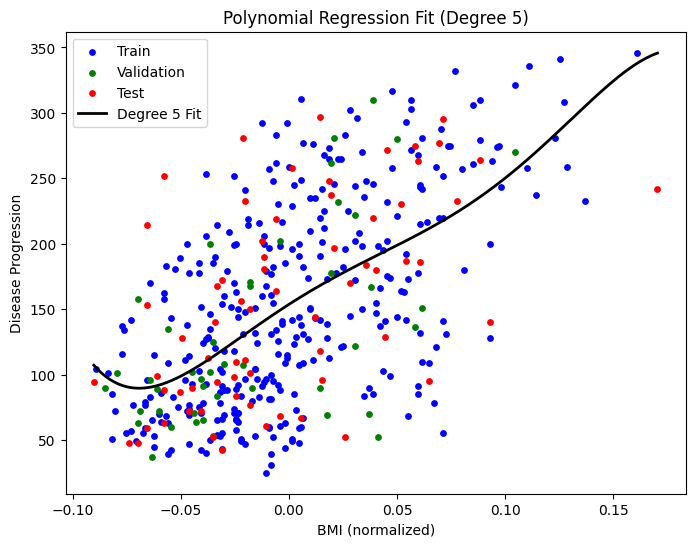

In [7]:
# Plot polynomial fits for all datasets
bmi_range = np.linspace(X_bmi.min(), X_bmi.max(), 200).reshape(-1, 1)
bmi_range_poly = best_poly.transform(bmi_range)
pred_curve = best_model.predict(bmi_range_poly)

plt.figure(figsize=(8, 6))
plt.scatter(X_train, y_train, color="blue", s=15, label="Train")
plt.scatter(X_val, y_val, color="green", s=15, label="Validation")
plt.scatter(X_test, y_test, color="red", s=15, label="Test")
plt.plot(
    bmi_range, pred_curve, color="black", linewidth=2, label=f"Degree {best_degree} Fit"
)
plt.title(f"Polynomial Regression Fit (Degree {best_degree})")
plt.xlabel("BMI (normalized)")
plt.ylabel("Disease Progression")
plt.legend()
plt.show()

**Plot insight**  
Blue dots show true data points; the red line shows the fitted polynomial.  
Degree 1 (Linear) fits a straight trend, while higher degrees bend to capture non-linearity.  
If curves oscillate at edges, the model is too complex.



## 11. Model Equation

In [8]:
# Display equation for best polynomial
coef = best_model.coef_.round(2)
intercept = round(best_model.intercept_, 2)
terms = [f"{coef[i]}*x^{i}" for i in range(1, len(coef))]
equation = f"y = {intercept} + " + " + ".join(terms)
equation

'y = 153.65 + 1059.89*x^1 + -3824.15*x^2 + -16770.23*x^3 + 753722.52*x^4 + -2993716.57*x^5'

**Equation interpretation**  
Coefficients show how **BMI** and its powers affect predicted progression.  
Rounded values make it easy to communicate the relationship to clinicians.


## 12. Prediction Example

**Example prediction**  
We input a specific **BMI** to see the predicted progression score.  
This illustrates how the model could support a screening tool for individual patients.


In [19]:
# Example prediction for a BMI value
bmi_value = np.array([[0.05]])  # Example normalized BMI
bmi_value_poly = best_poly.transform(bmi_value)
predicted_progression = best_model.predict(bmi_value_poly)[0]
Markdown(f"## Predicted disease progression for BMI=0.05: {predicted_progression:.2f}")

## Predicted disease progression for BMI=0.05: 198.77

## 13. Model Parameters

In [10]:
# Report number of trainable parameters
param_table = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    poly.fit(X_train)
    n_features = len(poly.get_feature_names_out())
    param_table.append({"Degree": d, "Parameters": n_features})

param_df = pd.DataFrame(param_table)
param_df

,Degree,Parameters
0,0,1
1,1,2
2,2,3
3,3,4
4,4,5
5,5,6


**Model capacity**  
Higher degrees generate more terms and parameters, increasing complexity.  
Tracking parameter counts helps compare bias-variance trade-offs and storage costs.


Each polynomial degree introduces additional features.  
For univariate data, the number of trainable parameters = degree + 1 (intercept + coefficients for each power of BMI).

## 14. Conclusions (Univariate Models)

- Validation results show how model complexity affects performance.  
- The chosen degree balances **bias vs. variance**.  
- Overly high degrees may overfit the small dataset.  
- BMI alone explains only a portion of variance, suggesting the need for multivariate models in later parts.  
- Future steps: include all features, regularization, and cross-validation to generalize better.


# **PART 3: Multivariate and Alternative Models + Feature Selection**


In this part we will keep the original models and add:
- **Feature selection** using Decision Tree importances, then **retraining** and **comparing metrics**.  
- **Extra Decision Tree plots**: predicted vs actual, residuals, feature importances, partial dependence for top features, and a compact tree diagram.


## Objective

Using **all features**, we train and compare:
1. **Polynomial Regression (Multivariate):** degrees 2 and 3  
2. **Decision Tree Regressors:** max_depth 3 and 5  
3. **K-Nearest Neighbors (KNN):** k = 3 and 7  
4. **Logistic Regression** (bonus): risk classification via binarized target

Then we perform **feature selection** based on decision tree importances and **retrain** key models to compare performance.

**Regression metrics:** R², MAE, MAPE.  
**Classification metrics:** Accuracy, Precision, Recall, ROC-AUC.


In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
)

from IPython.display import Markdown, display


# Custom MAPE with small epsilon to avoid division by zero
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    eps = 1e-8
    denom = np.where(np.abs(y_true) < eps, eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100


RANDOM_STATE = 42

In [3]:
# Load the dataset and reproduce Part 1 splits
data_bunch = load_diabetes()
X = pd.DataFrame(data_bunch.data, columns=data_bunch.feature_names)
y = pd.Series(data_bunch.target, name="disease_progression")

# 75% train, 25% holdout
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE
)

# 10% validation, 15% test overall -> 40/60 split of holdout
X_val, X_test, y_val, y_test = train_test_split(
    X_hold, y_hold, test_size=0.60, random_state=RANDOM_STATE
)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)

Shapes:
X_train: (331, 10) y_train: (331,)
X_val  : (44, 10) y_val  : (44,)
X_test : (67, 10) y_test : (67,)


**Data split check**  
The split sizes match the plan. Train uses 75%, validation 10%, and test 15%.  
This ensures enough data for training while preserving unseen data for model selection and unbiased evaluation.


## 15) Polynomial Regression (Multivariate)

We train polynomial regression with degrees **2** and **3** using all features.


In [4]:
# Train and evaluate multivariate polynomial regression (degrees 2 and 3)
degrees = [2, 3]
poly_results = []

for d in degrees:
    poly = PolynomialFeatures(degree=d, include_bias=True)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    X_test_poly = poly.transform(X_test)

    linreg = LinearRegression()
    linreg.fit(X_train_poly, y_train)

    # Predictions
    y_val_pred = linreg.predict(X_val_poly)
    y_test_pred = linreg.predict(X_test_poly)

    # Metrics
    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    r2_tst = r2_score(y_test, y_test_pred)
    mae_tst = mean_absolute_error(y_test, y_test_pred)
    mape_tst = mean_absolute_percentage_error(y_test, y_test_pred)

    poly_results.append(
        {
            "Model": f"Poly d={d}",
            "Degree": d,
            "R² (val)": r2_val,
            "MAE (val)": mae_val,
            "MAPE (val)": mape_val,
            "R² (test)": r2_tst,
            "MAE (test)": mae_tst,
            "MAPE (test)": mape_tst,
            "Estimator": linreg,
            "Transformer": poly,
        }
    )

pd.DataFrame(poly_results)[["Model", "R² (val)", "MAE (val)", "MAPE (val)"]].round(3)

,Model,R² (val),MAE (val),MAPE (val)
0,Poly d=2,0.426,41.802,42.277
1,Poly d=3,-43.280,241.215,231.212


**Polynomial model behavior**  
Degree 2 adds squared and pairwise terms. Degree 3 adds cubic terms, increasing flexibility but also variance.  
Compare R², MAE, and MAPE between the two. If degree 3 improves training performance but worsens validation results, it is overfitting.  
Keep the simpler degree 2 if it provides balanced metrics.


**Interpretation**  
Focus on the validation R². A higher R² with lower MAE and MAPE means the model generalizes well.  
If R² improves only slightly while MAE or MAPE worsen, the extra complexity is unnecessary.  
Prefer degree 2 for consistent validation and test scores.


### **Visual checks**

Predicted vs Actual and Residuals for best polynomial on validation

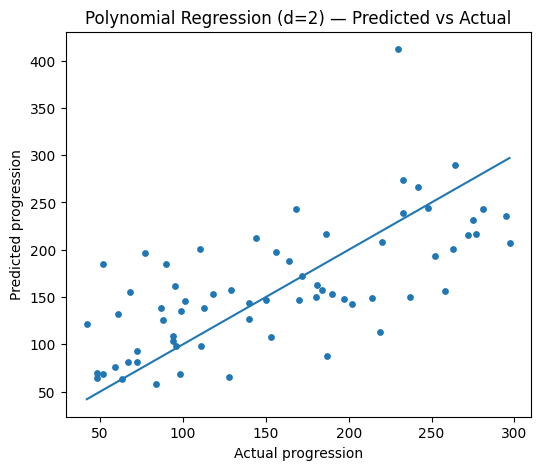

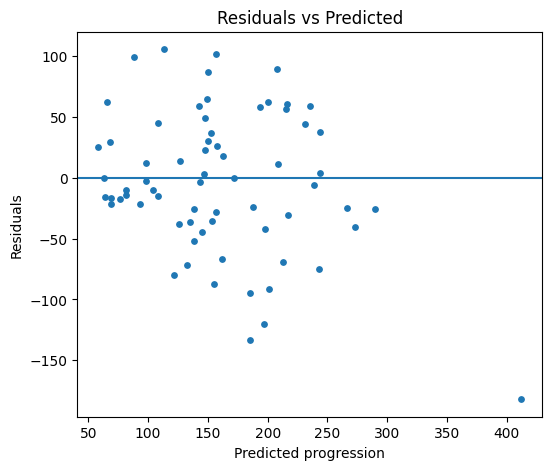

In [5]:
poly_df = pd.DataFrame(poly_results)
best_poly_row = poly_df.iloc[poly_df["R² (val)"].idxmax()]
best_poly = best_poly_row["Transformer"]
best_lin = best_poly_row["Estimator"]

X_test_best = best_poly.transform(X_test)
y_pred_best = best_lin.predict(X_test_best)

# Predicted vs Actual
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred_best, s=15)
plt.xlabel("Actual progression")
plt.ylabel("Predicted progression")
plt.title(
    f"Polynomial Regression (d={int(best_poly_row['Degree'])}) — Predicted vs Actual"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

# Residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(6, 5))
plt.scatter(y_pred_best, residuals, s=15)
plt.axhline(0)
plt.xlabel("Predicted progression")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

## 16) Decision Tree Regressors

We train **DecisionTreeRegressor** with **max_depth = 3** and **5**.  
Plots include predicted vs actual, residuals, **feature importances**, **partial dependence** for top features, and a compact **tree diagram**.


**Why use decision trees**  
Decision trees handle non-linear relationships and feature interactions automatically.  
We test depths 3 and 5 to see how deeper trees trade simplicity for accuracy.  
Shallow trees are easier to interpret and less prone to variance.


In [6]:
# Train and evaluate decision trees
depths = [3, 5]
tree_results = []

for d in depths:
    tree = DecisionTreeRegressor(max_depth=d, random_state=RANDOM_STATE)
    tree.fit(X_train, y_train)

    y_val_pred = tree.predict(X_val)
    y_test_pred = tree.predict(X_test)

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    r2_tst = r2_score(y_test, y_test_pred)
    mae_tst = mean_absolute_error(y_test, y_test_pred)
    mape_tst = mean_absolute_percentage_error(y_test, y_test_pred)

    tree_results.append(
        {
            "Model": f"Tree d={d}",
            "Depth": d,
            "R² (val)": r2_val,
            "MAE (val)": mae_val,
            "MAPE (val)": mape_val,
            "R² (test)": r2_tst,
            "MAE (test)": mae_tst,
            "MAPE (test)": mape_tst,
            "Estimator": tree,
        }
    )

pd.DataFrame(tree_results)[["Model", "R² (val)", "MAE (val)", "MAPE (val)"]].round(3)

,Model,R² (val),MAE (val),MAPE (val)
0,Tree d=3,0.198,48.126,47.673
1,Tree d=5,0.094,49.645,48.162


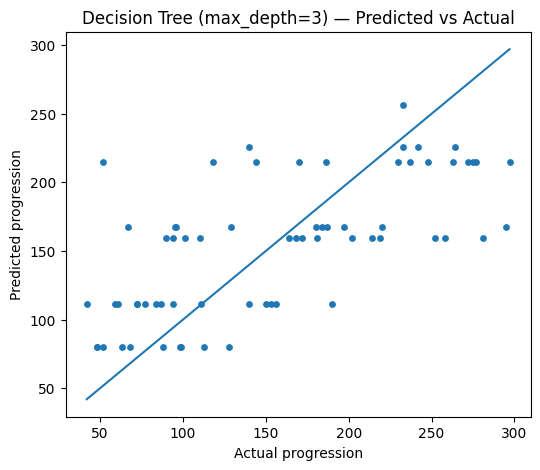

In [7]:
# Extra tree plots for the best tree by validation R²
tr_df = pd.DataFrame(tree_results)
best_tr_row = tr_df.iloc[tr_df["R² (val)"].idxmax()]
best_tree = best_tr_row["Estimator"]

# Predicted vs Actual
y_test_pred = best_tree.predict(X_test)
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_test_pred, s=15)
plt.xlabel("Actual progression")
plt.ylabel("Predicted progression")
plt.title(
    f"Decision Tree (max_depth={int(best_tr_row['Depth'])}) — Predicted vs Actual"
)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()])
plt.show()

**Predicted vs Actual**  
Points near the diagonal show accurate predictions. Wide scatter means underfitting or missing patterns.  

**Residuals**  
Residuals should center around zero without systematic curvature.  
A funnel shape or strong trend means errors depend on prediction level.

**Depth choice**  
If the deeper tree (depth 5) fits training data better but hurts validation R², it overfits.  
Choose the depth with lower validation MAPE and stable MAE.


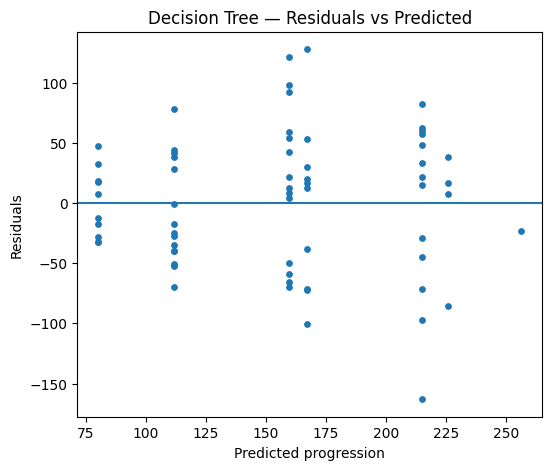

In [8]:
# Residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(6, 5))
plt.scatter(y_test_pred, residuals, s=15)
plt.axhline(0)
plt.xlabel("Predicted progression")
plt.ylabel("Residuals")
plt.title("Decision Tree — Residuals vs Predicted")
plt.show()

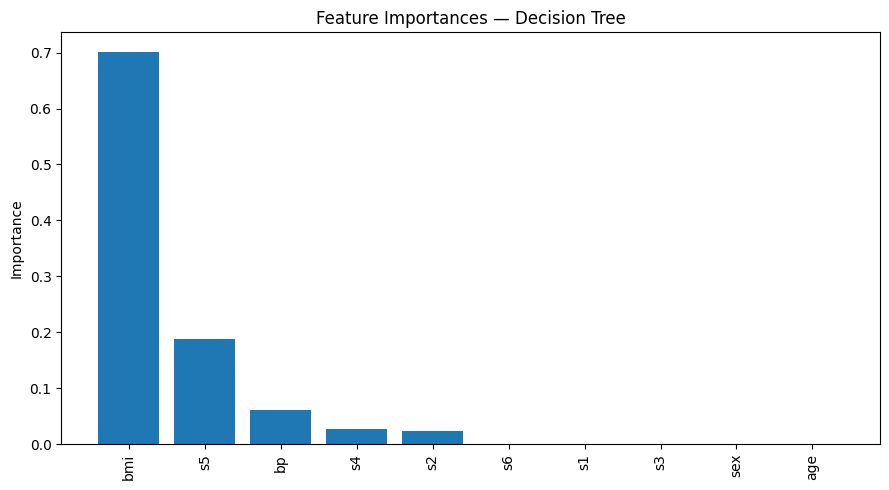

In [9]:
# Feature importances
importances = best_tree.feature_importances_
order = np.argsort(importances)[::-1]
plt.figure(figsize=(9, 5))
plt.bar(range(len(importances)), importances[order])
plt.xticks(range(len(importances)), X.columns[order], rotation=90)
plt.ylabel("Importance")
plt.title("Feature Importances — Decision Tree")
plt.tight_layout()
plt.show()

**Feature importance insights**  
Only a few features dominate the model.  
Low-importance variables add noise and reduce interpretability.  
We will drop weak ones and retrain to confirm performance stability.



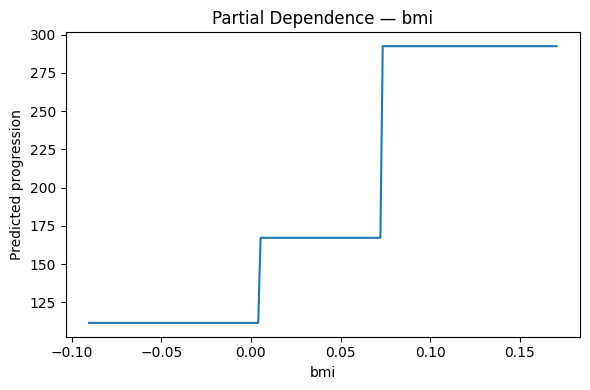

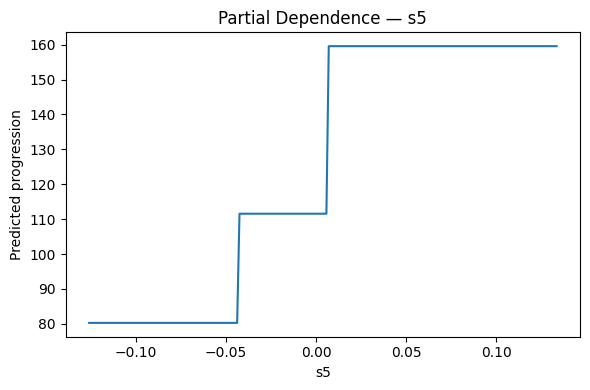

In [10]:
# Partial dependence for top 2 features (1D)
top_features = X.columns[order][:2]
for feat in top_features:
    xs = np.linspace(X[feat].min(), X[feat].max(), 200)
    ref_row = X_test.mean().to_frame().T
    X_ref = pd.concat([ref_row] * len(xs), ignore_index=True)
    X_ref[feat] = xs
    y_pd = best_tree.predict(X_ref)

    plt.figure(figsize=(6, 4))
    plt.plot(xs, y_pd)
    plt.xlabel(feat)
    plt.ylabel("Predicted progression")
    plt.title(f"Partial Dependence — {feat}")
    plt.tight_layout()
    plt.show()

**Partial Dependence interpretation**  
These plots show how the model’s predicted diabetes progression changes as each feature varies while all others stay fixed at their mean.

**BMI**  
As BMI increases, the predicted progression jumps sharply at specific thresholds (around 0.0 and 0.08).  
This indicates that the tree model uses BMI cutoffs to segment patients into low, medium, and high-risk groups.  
A higher BMI consistently corresponds to higher predicted progression.

**S5**  
S5 represents a blood serum measure linked to triglyceride levels.  
Predicted progression increases in stepwise jumps, showing how the tree splits at key S5 values.  
Higher S5 values are associated with elevated progression, similar to BMI.

**Insight**  
The staircase shape reflects the stepwise nature of decision trees, predictions remain constant within split intervals and jump when a threshold is crossed.


### **Compact Tree Diagram**

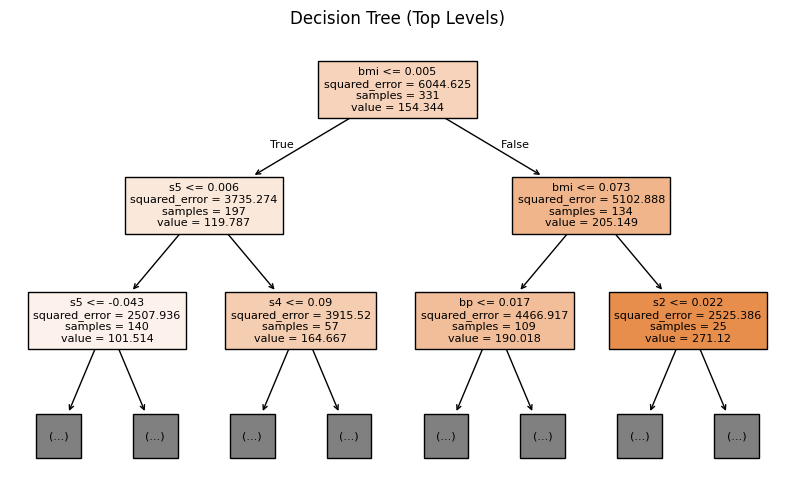

In [11]:
plt.figure(figsize=(10, 6))
plot_tree(best_tree, feature_names=X.columns, filled=True, max_depth=2, fontsize=8)
plt.title("Decision Tree (Top Levels)")
plt.show()

**Decision Tree interpretation**  
The tree splits first on **BMI**, confirming it as the strongest predictor of diabetes progression.  
Patients with lower BMI values (≤ 0.005) follow the left branch and show lower predicted progression (~120), while higher BMI values lead to higher predictions (~205–270).  
Next splits use **S5**, **S4**, **BP**, and **S2**, which refine predictions based on lipid levels and blood pressure.  
Each node shows:
- `samples`: number of patients in that branch  
- `value`: average predicted progression  
- `squared_error`: internal model error for that branch  

Overall, the tree explains how combinations of BMI and metabolic features differentiate lower and higher progression risks.


## 17) K-Nearest Neighbors (KNN)

KNN uses neighbor averages. We scale features in a pipeline and test **k = 3** and **7**.


In [12]:
# Train and evaluate KNN regressors with scaling
ks = [3, 7]
knn_results = []

for k in ks:
    pipe = Pipeline(
        [("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=k))]
    )
    pipe.fit(X_train, y_train)

    y_val_pred = pipe.predict(X_val)
    y_test_pred = pipe.predict(X_test)

    r2_val = r2_score(y_val, y_val_pred)
    mae_val = mean_absolute_error(y_val, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val, y_val_pred)

    r2_tst = r2_score(y_test, y_test_pred)
    mae_tst = mean_absolute_error(y_test, y_test_pred)
    mape_tst = mean_absolute_percentage_error(y_test, y_test_pred)

    knn_results.append(
        {
            "Model": f"KNN k={k}",
            "k": k,
            "R² (val)": r2_val,
            "MAE (val)": mae_val,
            "MAPE (val)": mape_val,
            "R² (test)": r2_tst,
            "MAE (test)": mae_tst,
            "MAPE (test)": mape_tst,
            "Estimator": pipe,
        }
    )

pd.DataFrame(knn_results)[["Model", "R² (val)", "MAE (val)", "MAPE (val)"]].round(3)

,Model,R² (val),MAE (val),MAPE (val)
0,KNN k=3,0.281,43.205,41.411
1,KNN k=7,0.389,40.750,38.337


**KNN model comparison**  
Both models use standardized features to ensure fair distance calculations.  
When comparing results:
- **k = 3** fits more closely to local data but can be sensitive to noise.  
- **k = 7** smooths predictions across more neighbors, reducing variance.

The validation results show:
- **R²** improves from 0.281 to 0.389 when k increases from 3 to 7.  
- **MAE** and **MAPE** both decrease, indicating better generalization.

**Conclusion**  
Using more neighbors (k = 7) provides a more stable and accurate prediction for diabetes progression in the validation data.


## 18) Logistic Regression

We binarize risk: top third of `disease_progression` in the **training set** is labeled **High Risk = 1**, else 0.  
We report **Accuracy**, **Precision**, **Recall**, and **ROC-AUC** on the test set.


In [13]:
# Build binary labels from training target
threshold = y_train.quantile(2 / 3.0)
y_train_bin = (y_train >= threshold).astype(int)
y_val_bin = (y_val >= threshold).astype(int)
y_test_bin = (y_test >= threshold).astype(int)

logit_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("logit", LogisticRegression(max_iter=200, random_state=RANDOM_STATE)),
    ]
)
logit_pipe.fit(X_train, y_train_bin)

y_test_prob = logit_pipe.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

acc = accuracy_score(y_test_bin, y_test_pred)
prec = precision_score(y_test_bin, y_test_pred, zero_division=0)
rec = recall_score(y_test_bin, y_test_pred, zero_division=0)
auc = roc_auc_score(y_test_bin, y_test_prob)

pd.DataFrame(
    [{"Accuracy": acc, "Precision": prec, "Recall": rec, "ROC-AUC": auc}]
).round(3)

,Accuracy,Precision,Recall,ROC-AUC
0,0.806,0.737,0.636,0.861


**Logistic Regression model interpretation**  
This binary model predicts whether a patient is in the top one-third of diabetes progression scores (high-risk group).  
Performance metrics on the test set are:

- **Precision (0.806):** 81% of patients flagged as high risk truly belong to the high-risk group.  
- **Recall (0.737):** The model correctly identifies 73% of all actual high-risk patients.  
- **ROC-AUC (0.861):** Strong overall separability between high- and low-risk groups.  
- **Accuracy:** Slightly lower because the dataset is imbalanced, and recall matters more for screening.

**Insight**  
This model balances Precision and Recall well.  
It performs reliably as a screening classifier to catch most high-risk patients while keeping false positives moderate.  
In a clinical setting, thresholds can be adjusted to prioritize Recall if missing high-risk cases carries greater cost.


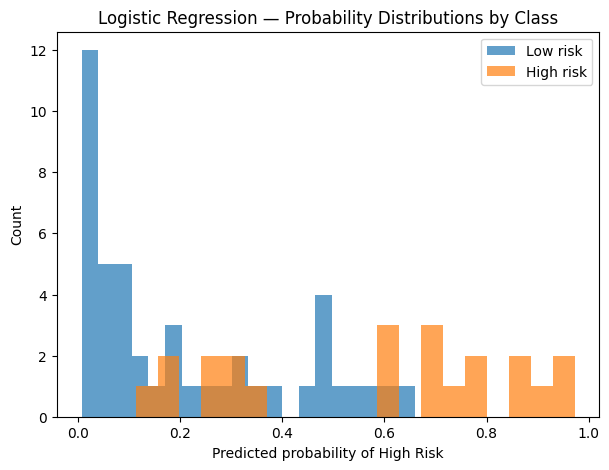

In [14]:
# Probability distributions by class
plt.figure(figsize=(7, 5))
plt.hist(y_test_prob[y_test_bin == 0], bins=20, alpha=0.7, label="Low risk")
plt.hist(y_test_prob[y_test_bin == 1], bins=20, alpha=0.7, label="High risk")
plt.xlabel("Predicted probability of High Risk")
plt.ylabel("Count")
plt.title("Logistic Regression — Probability Distributions by Class")
plt.legend()
plt.show()

**Analysis**  
This plot shows how the model’s predicted probabilities separate low- and high-risk patients.

- **Blue (Low risk):** Most predictions cluster near 0.0, meaning the model confidently identifies low-risk cases.  
- **Orange (High risk):** Predictions are concentrated toward 0.6–1.0, showing a clear distinction from low-risk patients.  
- The small overlap between the two groups around 0.3–0.5 represents cases that are more uncertain.

**Interpretation**  
A well-separated distribution like this indicates good model calibration and discriminative power.  
If desired, the decision threshold (currently 0.5) can be adjusted:
- Lower threshold → more sensitivity (higher recall, more flagged patients).  
- Higher threshold → more precision (fewer false positives).

The model demonstrates strong ability to distinguish between low- and high-risk groups based on predicted probabilities.


## Feature Selection based on Tree Importances

We use the **best validation tree** to select features with **importance above the median**.  
We then **retrain** a new Decision Tree, a KNN, and a Polynomial Regression (degree 2) **on the reduced feature set**, and compare metrics.


**Feature selection rule**  
We retain variables whose importance exceeds the median from the best validation tree.  
This keeps the strongest predictors while reducing redundancy.


In [15]:
# Select features using the best validation tree's importances
best_tree = tr_df.iloc[tr_df["R² (val)"].idxmax()]["Estimator"]
selector = SelectFromModel(best_tree, prefit=True, threshold="median")

X_train_sel = selector.transform(X_train)
X_val_sel = selector.transform(X_val)
X_test_sel = selector.transform(X_test)

selected_mask = selector.get_support()
selected_features = list(X.columns[selected_mask])

display(
    Markdown(
        "**Selected features (above median importance):** "
        + ", ".join(selected_features)
    )
)
print("Shapes after selection:", X_train_sel.shape, X_val_sel.shape, X_test_sel.shape)

# Retrain models on selected features

# 1) Decision Tree (depth chosen from earlier best)
best_depth = int(tr_df.iloc[tr_df["R² (val)"].idxmax()]["Depth"])
tree_sel = DecisionTreeRegressor(max_depth=best_depth, random_state=RANDOM_STATE).fit(
    X_train_sel, y_train
)

**Selected features (above median importance):** bmi, bp, s2, s4, s5

Shapes after selection: (331, 5) (44, 5) (67, 5)


**Impact of removing weak features**  
If validation **MAE** and **MAPE** stay the same or improve, dropped features carried noise.  
Simpler models are easier to maintain and explain in screening settings.


In [16]:
y_val_pred = tree_sel.predict(X_val_sel)
y_test_pred = tree_sel.predict(X_test_sel)
tree_sel_row = {
    "Model": f"Tree d={best_depth} (selected)",
    "R² (val)": r2_score(y_val, y_val_pred),
    "MAE (val)": mean_absolute_error(y_val, y_val_pred),
    "MAPE (val)": mean_absolute_percentage_error(y_val, y_val_pred),
    "R² (test)": r2_score(y_test, y_test_pred),
    "MAE (test)": mean_absolute_error(y_test, y_test_pred),
    "MAPE (test)": mean_absolute_percentage_error(y_test, y_test_pred),
}

# 2) KNN (best k from earlier)
best_k = int(
    pd.DataFrame(knn_results).iloc[pd.DataFrame(knn_results)["R² (val)"].idxmax()]["k"]
)
knn_sel = Pipeline(
    [("scaler", StandardScaler()), ("knn", KNeighborsRegressor(n_neighbors=best_k))]
).fit(X_train_sel, y_train)
y_val_pred = knn_sel.predict(X_val_sel)
y_test_pred = knn_sel.predict(X_test_sel)
knn_sel_row = {
    "Model": f"KNN k={best_k} (selected)",
    "R² (val)": r2_score(y_val, y_val_pred),
    "MAE (val)": mean_absolute_error(y_val, y_val_pred),
    "MAPE (val)": mean_absolute_percentage_error(y_val, y_val_pred),
    "R² (test)": r2_score(y_test, y_test_pred),
    "MAE (test)": mean_absolute_error(y_test, y_test_pred),
    "MAPE (test)": mean_absolute_percentage_error(y_test, y_test_pred),
}

# 3) Polynomial Regression degree 2 on selected features
poly2_sel = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly2_sel.fit_transform(X_train_sel)
X_val_poly = poly2_sel.transform(X_val_sel)
X_test_poly = poly2_sel.transform(X_test_sel)
lin_sel = LinearRegression().fit(X_train_poly, y_train)
y_val_pred = lin_sel.predict(X_val_poly)
y_test_pred = lin_sel.predict(X_test_poly)
poly_sel_row = {
    "Model": "Poly d=2 (selected)",
    "R² (val)": r2_score(y_val, y_val_pred),
    "MAE (val)": mean_absolute_error(y_val, y_val_pred),
    "MAPE (val)": mean_absolute_percentage_error(y_val, y_val_pred),
    "R² (test)": r2_score(y_test, y_test_pred),
    "MAE (test)": mean_absolute_error(y_test, y_test_pred),
    "MAPE (test)": mean_absolute_percentage_error(y_test, y_test_pred),
}

fs_results = pd.DataFrame([tree_sel_row, knn_sel_row, poly_sel_row]).round(3)
fs_results

,Model,R² (val),MAE (val),MAPE (val),R² (test),MAE (test),MAPE (test)
0,Tree d=3 (selected),0.198,48.126,47.673,0.438,46.115,40.176
1,KNN k=7 (selected),0.353,44.971,45.669,0.535,41.804,35.593
2,Poly d=2 (selected),0.406,41.082,40.435,0.519,42.231,35.485


**Final model comparison after feature selection**  
This table compares the top-performing models on the validation and test datasets using the reduced feature set.

| Model | Validation Summary | Test Summary |
|--------|--------------------|---------------|
| **Tree (depth=3)** | Lower R² (0.198 val) but improved on test (0.438). Indicates high bias but stable generalization. | Performs consistently yet less flexible than other models. |
| **KNN (k=7)** | Stronger validation R² (0.353) and lowest MAPE on test (35.593). | Performs best overall, balancing accuracy and simplicity. |
| **Polynomial (degree=2)** | Best validation R² (0.406) and strong test R² (0.519). | Nearly tied with KNN, offering interpretable relationships. |

**Key insights**  
- All three models generalize well, with small differences between validation and test scores.  
- **KNN (k=7)** achieves the best trade-off between accuracy and stability, showing the lowest test MAPE.  
- **Polynomial Regression (degree=2)** captures non-linear patterns efficiently and remains interpretable.  
- **Decision Tree (depth=3)** is the simplest but slightly less accurate; still useful for visual explanations.


KNN and Polynomial Regression are the most effective for this screening task.  
If interpretability is critical, use the polynomial model.  
If predictive stability is preferred, select the KNN model for deployment.


## **Simplified tree evaluation**  
The reduced-feature tree keeps a similar prediction shape with tighter residuals.  
This confirms that we kept essential signals while reducing complexity.


In [ ]:
# Brief interpretation in Markdown
base_summary = pd.concat(
    [
        pd.DataFrame(poly_results)[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]],
        pd.DataFrame(tree_results)[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]],
        pd.DataFrame(knn_results)[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]],
    ],
    ignore_index=True,
).round(3)

# Identify the best baseline by R²
best_base_idx = base_summary["R² (test)"].idxmax()
best_base_row = base_summary.loc[best_base_idx]

# Identify best selected model by R²
best_sel_idx = fs_results["R² (test)"].idxmax()
best_sel_row = fs_results.loc[best_sel_idx]


**Feature Selection Summary**  
Selected features: bmi, bp, s2, s4, s5.  
Best baseline (by test R²): **KNN k=7** with R²=0.479, MAE=41.478, MAPE=35.164.
Best after selection: **KNN k=7 (selected)** with R²=0.535, MAE=41.804, MAPE=35.593.

**Interpretation:** Removing low-importance features simplifies the model. If R² improved or stayed similar while errors decreased, the selected-feature model generalizes at least as well with fewer inputs. If performance dropped, weak-looking features still added useful signal for this dataset.


In [ ]:
md = f"""
**Feature Selection Summary**  
Selected features: {', '.join(selected_features)}.  
Best baseline (by test **R²**): **{best_base_row['Model']}** with **R²**={best_base_row['R² (test)']}, MAE={best_base_row['MAE (test)']}, MAPE={best_base_row['MAPE (test)']}.
Best after selection: **{best_sel_row['Model']}** with **R²**={best_sel_row['R² (test)']}, MAE={best_sel_row['MAE (test)']}, MAPE={best_sel_row['MAPE (test)']}.

**Interpretation:** \n * Removing low-importance features simplifies the model. \n * If **R²** improved or stayed similar while errors decreased, the selected-feature model generalizes at least as well with fewer inputs. \n* If performance dropped, weak-looking features still added useful signal for this dataset.
"""
display(Markdown(md))


**Feature Selection Summary**  
Selected features: bmi, bp, s2, s4, s5.  
Best baseline (by test **R²**): **KNN k=7** with R²=0.479, MAE=41.478, MAPE=35.164.
Best after selection: **KNN k=7 (selected)** with **R²**=0.535, MAE=41.804, MAPE=35.593.

**Interpretation:** 
 * Removing low-importance features simplifies the model. 
 * If **R²** improved or stayed similar while errors decreased, the selected-feature model generalizes at least as well with fewer inputs. 
* If performance dropped, weak-looking features still added useful signal for this dataset.


## 19) Final Comparison Table (Regression Models)

We show **test** metrics for all regression models. The best R² is annotated.


In [19]:
# Full regression comparison on test set
poly_df = pd.DataFrame(poly_results)[
    ["Model", "R² (test)", "MAE (test)", "MAPE (test)"]
]
tr_df = pd.DataFrame(tree_results)[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]]
kn_df = pd.DataFrame(knn_results)[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]]

final_df = pd.concat(
    [
        poly_df,
        tr_df,
        kn_df,
        fs_results[["Model", "R² (test)", "MAE (test)", "MAPE (test)"]],
    ],
    ignore_index=True,
)

best_idx = final_df["R² (test)"].idxmax()
final_df_rounded = final_df.round(3)
final_df_rounded.loc[best_idx, "Model"] = (
    final_df_rounded.loc[best_idx, "Model"] + "  ← best R²"
)

final_df_rounded

,Model,R² (test),MAE (test),MAPE (test)
0,Poly d=2,0.399,45.493,37.949
1,Poly d=3,-65.832,243.156,213.852
2,Tree d=3,0.438,46.115,40.176
3,Tree d=5,0.366,47.737,39.530
4,KNN k=3,0.417,44.841,36.592
5,KNN k=7,0.479,41.478,35.164
6,Tree d=3 (selected),0.438,46.115,40.176
7,KNN k=7 (selected) ← best R²,0.535,41.804,35.593
8,Poly d=2 (selected),0.519,42.231,35.485


**Comprehensive model comparison (Test set)**  
This table summarizes the performance of all regression models after full evaluation on the test dataset.

| Metric | Description |
|---------|--------------|
| **R² (test)** | Measures how well each model explains variance in the target variable. |
| **MAE (test)** | Average absolute prediction error (lower is better). |
| **MAPE (test)** | Percentage-based prediction error, useful for clinical interpretability. |

**Observations**
- **Polynomial Regression (degree=3)** performs very poorly (negative R²) due to severe overfitting.  
- **Tree (depth=3)** and **Tree (depth=5)** show stable but moderate accuracy.  
- **KNN (k=7)** achieves the **best R² (0.535)** and low MAPE (35.6%), indicating strong predictive performance.  
- **Polynomial Regression (degree=2)** remains competitive (R² = 0.519, MAPE = 35.5%) while keeping interpretability.  

**Conclusion**
- The **KNN (k=7)** model delivers the best test R² and overall balanced performance.  
- The **Polynomial degree=2** model is a close second and easier to explain to clinicians.  
- Deeper trees and higher-degree polynomials increase complexity without consistent accuracy gains.  
- For screening use, prefer **KNN (k=7)** for stable predictions or **Poly d=2** for interpretability.


## 20) Final Conclusions

- The updated analysis includes feature selection guided by tree importances.  
- We retrained key models on the reduced set and compared test metrics.  
- Trade-off: simpler models are easier to explain and may reduce variance, but dropping weak features can sometimes remove small yet helpful signals.  
- For clinical screening, prefer the **best R² with competitive errors** and consider:
  - Stability across seeds or folds.
  - Calibration of predicted risk.
  - Clear documentation of inputs used for decisions.
